<a href="https://colab.research.google.com/github/dileep9968/Fine-Tune-BERT-For-Multiclass-classification-on-twitter-sentiment-data/blob/main/fine_tunned_BERT_for_multiclass_classification_on_twitter_sentiment_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 11.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that a

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv')

In [3]:
df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [5]:
df.isnull().sum()

,0
text,0
label,0
label_name,0


In [6]:
df.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


In [7]:
df['label'].value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


## Data Analysism

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

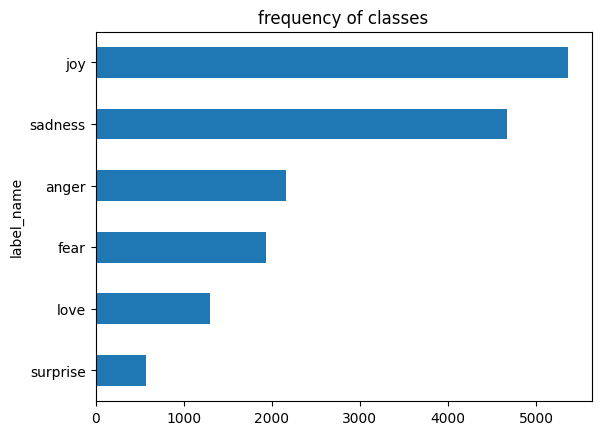

In [9]:
label_counts = df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title('frequency of classes')
plt.show()

<Axes: title={'center': 'words_per_tweet'}, xlabel='label_name'>

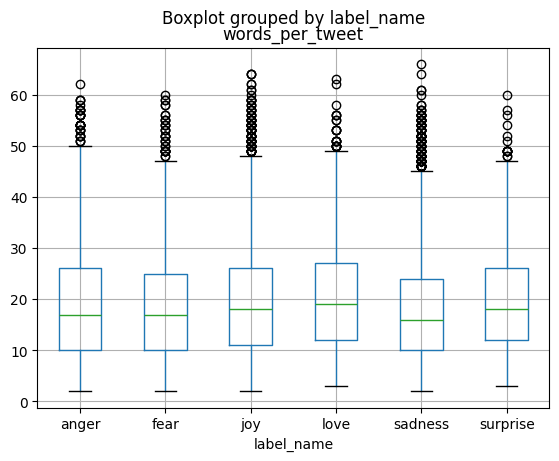

In [10]:
df['words_per_tweet'] = df['text'].str.split().apply(len)
df.boxplot('words_per_tweet', by='label_name')

## Text to tokens conversion

In [11]:
from transformers import AutoTokenizer
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
txt = 'I love generative AI'
tokens = tokenizer.tokenize(txt)
encoded_token = tokenizer(txt)
print(tokens)
print(encoded_token)

['i', 'love', 'genera', '##tive', 'ai']
{'input_ids': [101, 1045, 2293, 11416, 6024, 9932, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


In [13]:
len(tokenizer.vocab), tokenizer.vocab_size

(30522, 30522)

## DataLoader and Train Test Split

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3,
                               stratify=df['label_name'],
                               random_state=42)
test, valid = train_test_split(test, test_size =1/3,
                               stratify = test['label_name'])
train.shape, test.shape, valid.shape

((11200, 4), (3200, 4), (1600, 4))

In [15]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({'train': Dataset.from_pandas(train, preserve_index=False),
                      'test': Dataset.from_pandas(test, preserve_index = False),
                      'valid': Dataset.from_pandas(valid, preserve_index=False)})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 3200
    })
    valid: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 1600
    })
})

## Tokenization of the Emotion / Sentiment datam

In [16]:
dataset['train'][0]

{'text': 'i feel unhappy it is no help for me that other persons say that i am happy how much truth there may be in it',
 'label': 0,
 'label_name': 'sadness',
 'words_per_tweet': 25}

In [17]:
def tokenize(batch):
  temp = tokenizer(batch['text'], padding=True, truncation=True)
  return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1045, 2514, 12511, 2009, 2003, 2053, 2393, 2005, 2033, 2008, 2060, 5381, 2360, 2008, 1045, 2572, 3407, 2129, 2172, 3606, 2045, 2089, 2022, 1999, 2009, 102], [101, 1045, 2001, 3110, 9191, 2043, 1045, 4149, 2009, 1998, 4415, 2043, 1045, 2001, 2725, 2026, 5789, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [18]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [19]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    valid: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In [20]:
# label2id, id2label

label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k, v in label2id.items()}
label2id, id2label

({'sadness': 0, 'joy': 1, 'fear': 4, 'surprise': 5, 'anger': 3, 'love': 2},
 {0: 'sadness', 1: 'joy', 4: 'fear', 5: 'surprise', 3: 'anger', 2: 'love'})

## Model Building

In [21]:
from transformers import AutoModel
import torch

In [22]:
model = AutoModel.from_pretrained(model_ckpt)
model

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [23]:
# total parameter
total_params = sum(p.numel() for p in model.parameters())
traiable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')
print(f'Traiable parameters: {traiable_params}')

Total parameters: 109482240
Traiable parameters: 109482240


In [24]:
model.config.architectures

['BertForMaskedLM']

In [25]:
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [26]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = AutoConfig.from_pretrained(model_ckpt,
                                    label2id = label2id,
                                    id2label = id2label)

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           config= config).to(device)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [28]:
from transformers import TrainingArguments

batch_size=64
training_dir = 'bert_base_train_dir'

training_args = TrainingArguments(
    output_dir = training_dir,
    overwrite_output_dir=True,
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    disable_tqdm = False
)



In [30]:
# Build compute metric
#!pip install evaluate
import evaluate
import numpy as np
accuracy = evaluate.load('accuracy')

def compute_metrics(pred):
  predictions, labels = pred
  preds = np.argmax(predictions, axis = 1)
  return accuracy.compute(predictions=preds, references=labels)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00


In [31]:
# use sklearn to build compute metric
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  acc = accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average='weighted')
  precision = precision_score(labels, preds, average='weighted')
  recall = recall_score(labels, preds, average='weighted')
  return {'accuracy':acc,
          'f1':f1,
          'precision':precision,
          'recall':recall}

## Trainer

In [32]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = emotion_encoded['train'],
    eval_dataset = emotion_encoded['valid'],
    tokenizer = tokenizer
)

<ipython-input-32-4c015e67f440>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [33]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss


TrainOutput(global_step=350, training_loss=0.836639142717634, metrics={'train_runtime': 354.6149, 'train_samples_per_second': 63.167, 'train_steps_per_second': 0.987, 'total_flos': 1001502421516800.0, 'train_loss': 0.836639142717634, 'epoch': 2.0})

## Model Evaluation

In [34]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.35197925567626953,
 'test_accuracy': 0.8925,
 'test_f1': 0.8906200737591528,
 'test_precision': 0.8920967769960267,
 'test_recall': 0.8925,
 'test_runtime': 12.7503,
 'test_samples_per_second': 250.974,
 'test_steps_per_second': 3.921}

In [36]:
preds_output.predictions

array([[-1.5619444 ,  3.208731  , -0.33986348, -1.5775415 , -0.21867754,
         0.5539195 ],
       [-1.170828  ,  3.7515895 , -0.55458826, -1.4755089 , -0.8312976 ,
         0.2731865 ],
       [ 3.8900576 , -0.31209797, -0.4771086 , -0.09571657, -0.5440916 ,
        -1.1702273 ],
       ...,
       [ 0.35206053,  3.3799164 ,  0.35162705, -1.3002983 , -1.4129694 ,
        -1.1037899 ],
       [-1.4709176 ,  2.8778563 ,  2.0667763 , -1.7289265 , -1.661508  ,
        -0.66760194],
       [-1.0421065 ,  4.039552  , -0.07849112, -1.4754305 , -1.2784731 ,
        -0.46443394]], dtype=float32)

In [39]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']


In [40]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       933
           1       0.91      0.91      0.91      1072
           2       0.79      0.70      0.74       261
           3       0.88      0.89      0.88       432
           4       0.85      0.90      0.87       387
           5       0.93      0.61      0.74       115

    accuracy                           0.89      3200
   macro avg       0.88      0.83      0.85      3200
weighted avg       0.89      0.89      0.89      3200



In [41]:
# plot confusion matrix

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

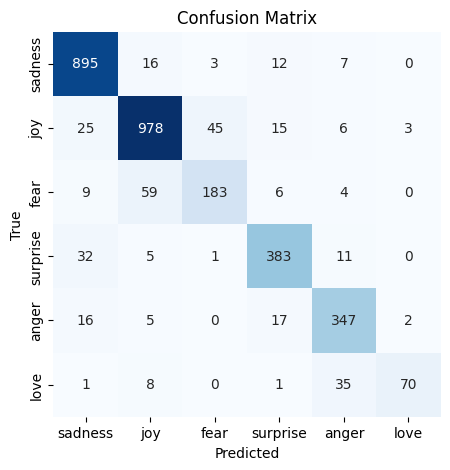

In [44]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(),
            yticklabels=label2id.keys(),
            fmt='d', cmap='Blues',cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Store Model and Build Prediction Function

In [47]:
txt= "I'm super happy today. i got it done. finnaly done"

def get_prediction(txt):
  input_encoded = tokenizer(txt, return_tensors='pt').to(device)

  with torch.no_grad():
    output = model(**input_encoded)

  logits = output.logits
  preds = torch.argmax(logits, dim=1).item()
  return id2label[preds]

get_prediction(txt)

'joy'

In [48]:
# saving model
trainer.save_model('bert-base-uncased-sentiment-model')

In [50]:
# use pipeline for prdiction
from transformers import pipeline

classifier = pipeline('text-classification', model='bert-base-uncased-sentiment-model')
classifier(txt)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'joy', 'score': 0.9400922656059265}]